In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [3]:
offtrain=pd.read_csv('ccf_offline_stage1_train.csv')
ontrain=pd.read_csv('ccf_online_stage1_train.csv')
offtest=pd.read_csv('ccf_offline_stage1_test_revised.csv')
sample=pd.read_csv('sample_submission.csv')

## 数据清理

In [4]:
ontrain.isnull().sum() 

User_id                 0
Merchant_id             0
Action                  0
Coupon_id        10557469
Discount_rate    10557469
Date_received    10557469
Date               655898
dtype: int64

In [5]:
offtrain.isnull().sum() 

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

可见优惠券有大量缺失值，但是其意义为未领取到优惠券，故保留。
同理，其他数据的缺失值均有实际意义，故保留。

In [6]:
## 将时间转换为可计算的datetime
offtrain['Date_received']=pd.to_datetime(offtrain['Date_received'], format='%Y%m%d')
offtrain['Date']=pd.to_datetime(offtrain['Date'], format='%Y%m%d')
ontrain['Date_received']=pd.to_datetime(ontrain['Date_received'], format='%Y%m%d')
ontrain['Date']=pd.to_datetime(ontrain['Date'], format='%Y%m%d')
offtest['Date_received']=pd.to_datetime(offtest['Date_received'], format='%Y%m%d')

In [7]:
##  添加是否在15天内使用优惠券
offtrain['使用间隔'] = offtrain['Date']-offtrain['Date_received']
offtrain['15天内使用'] = offtrain['使用间隔'] <= '15 days'
ontrain['使用间隔']= ontrain['Date']-ontrain['Date_received']
ontrain['15天内使用']= ontrain['使用间隔'] <= '15 days'

In [8]:
## 因为工作与非工作日对消费行为通常有很大影响，添加星期
offtrain['星期']= offtrain['Date_received'].apply(lambda x: x.weekday())
ontrain['星期']= ontrain['Date_received'].apply(lambda x: x.weekday())

## 根据消费日期和使用日期添加Y变量，将15天内使用定义为1，15天内未使用为0，未领劵的样本暂不考虑加入Y，但是可以在特征工程中纳入总体消费频率。

In [24]:
on_cupon=ontrain[ontrain.Date_received.notnull()]
off_cupon=offtrain[offtrain.Date_received.notnull()]

## 图表对比分析

<AxesSubplot:xlabel='Date_received'>

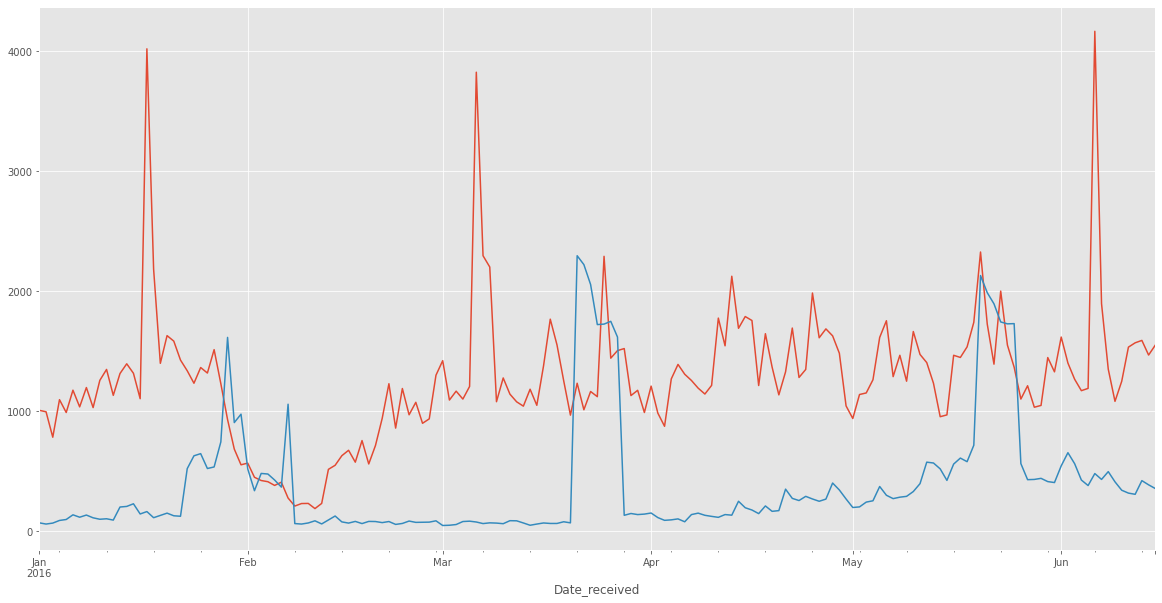

In [25]:
# 每日线上线下发出的优惠券 核销数量
on_cupon.groupby('Date_received')['15天内使用'].sum().plot()
off_cupon.groupby('Date_received')['15天内使用'].sum().plot()

<AxesSubplot:xlabel='Date_received'>

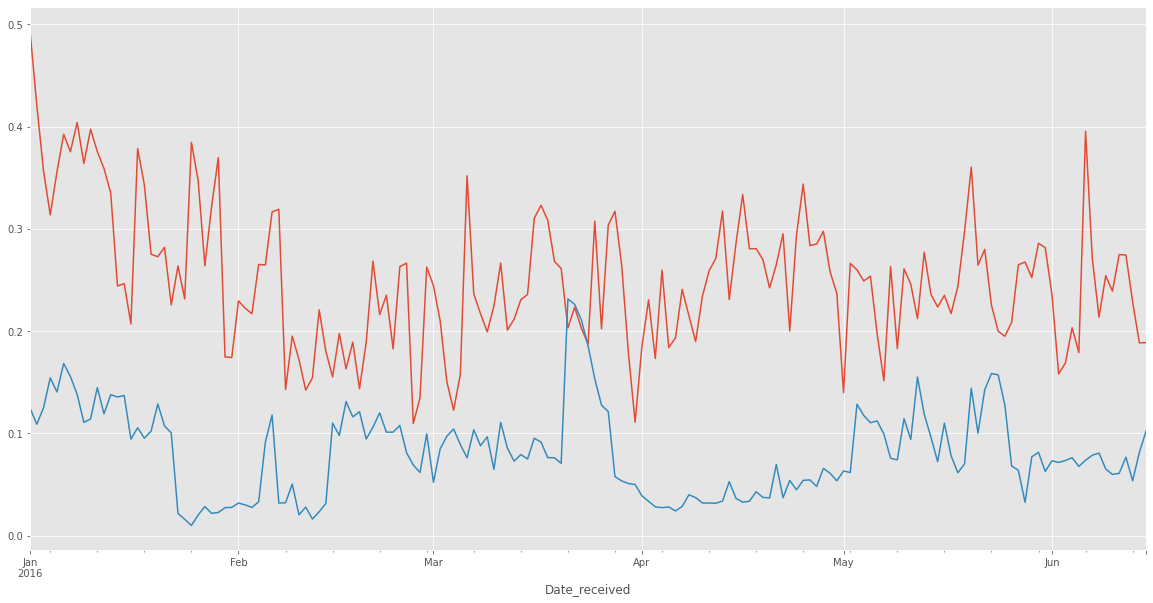

In [26]:

# 每日线上线下发出的优惠券 核销占当天发出数目的比例

on_cupon.groupby('Date_received')['15天内使用'].apply(lambda x: x.sum()/x.count()).plot()
off_cupon.groupby('Date_received')['15天内使用'].apply(lambda x: x.sum()/x.count()).plot()

<AxesSubplot:xlabel='星期'>

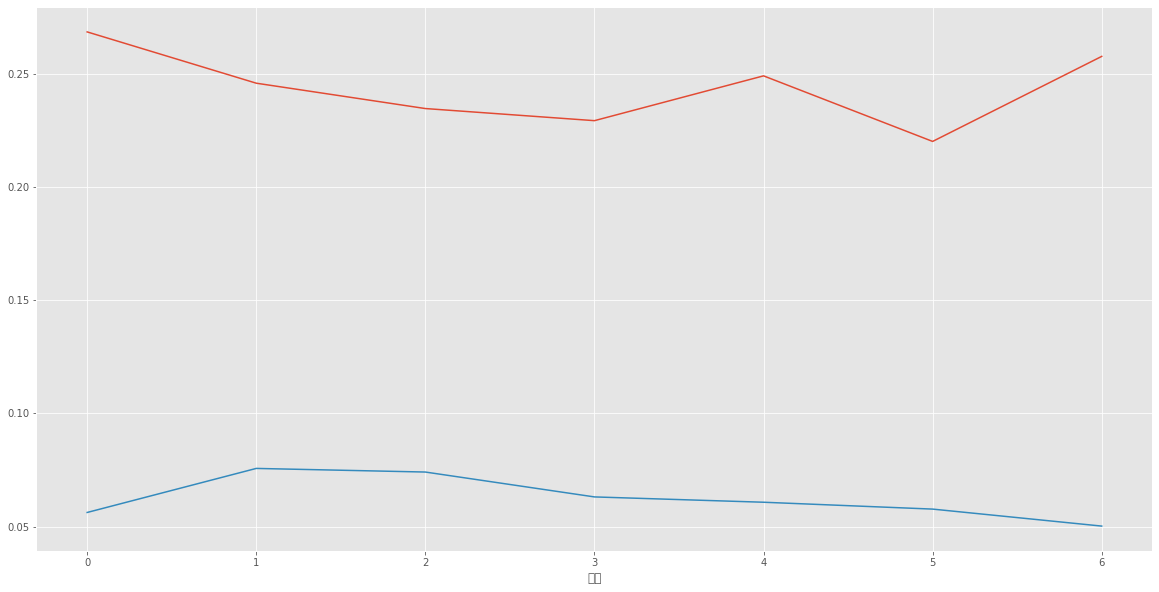

In [27]:
## 核销率按星期分布图

on_cupon.groupby('星期')['15天内使用'].apply(lambda x: x.sum()/x.count()).plot()
off_cupon.groupby('星期')['15天内使用'].apply(lambda x: x.sum()/x.count()).plot()

<AxesSubplot:xlabel='星期'>

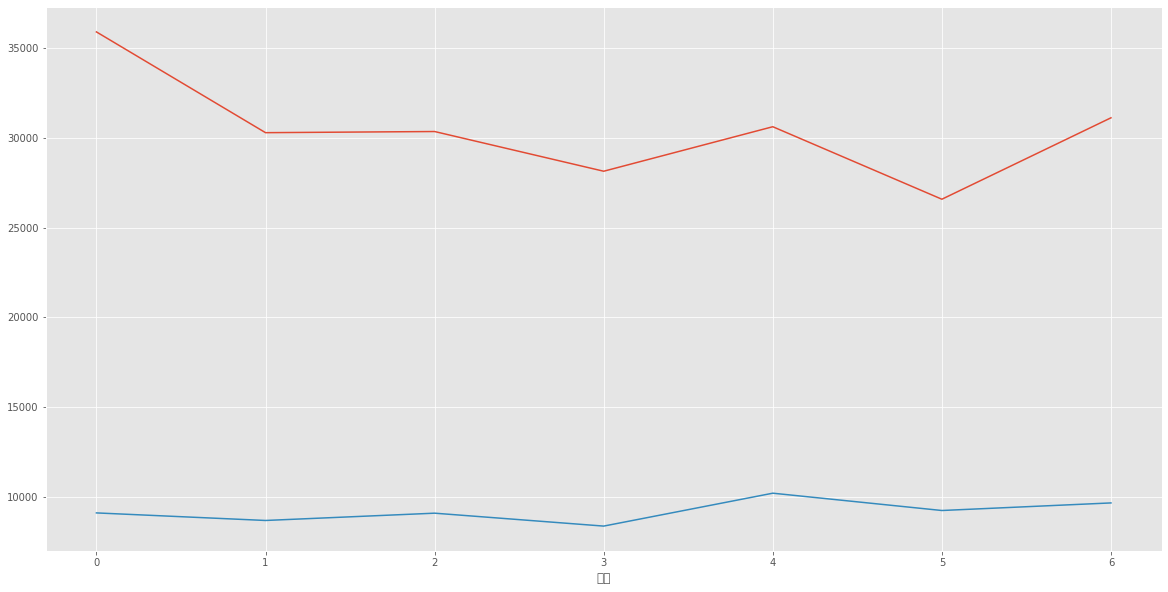

In [28]:
# 每日线上线下发出的优惠券 核销数量
on_cupon.groupby('星期')['15天内使用'].sum().plot()
off_cupon.groupby('星期')['15天内使用'].sum().plot()

Text(0.5, 0, 'Top 5 DAY')

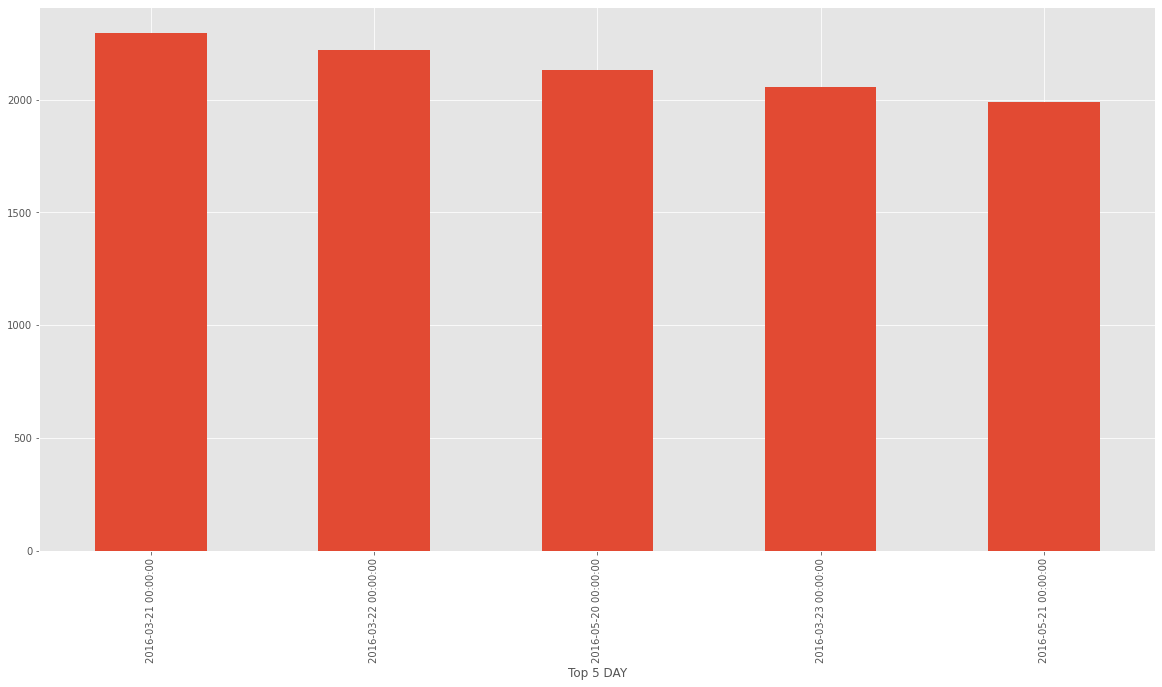

In [29]:
## 线下发放消费券 核销最高的几天
off_cupon.groupby('Date_received')['15天内使用'].sum().sort_values(ascending=False).head(5).plot(kind='bar')
plt.xlabel('Top 5 DAY')

Text(0, 0.5, 'log frequency')

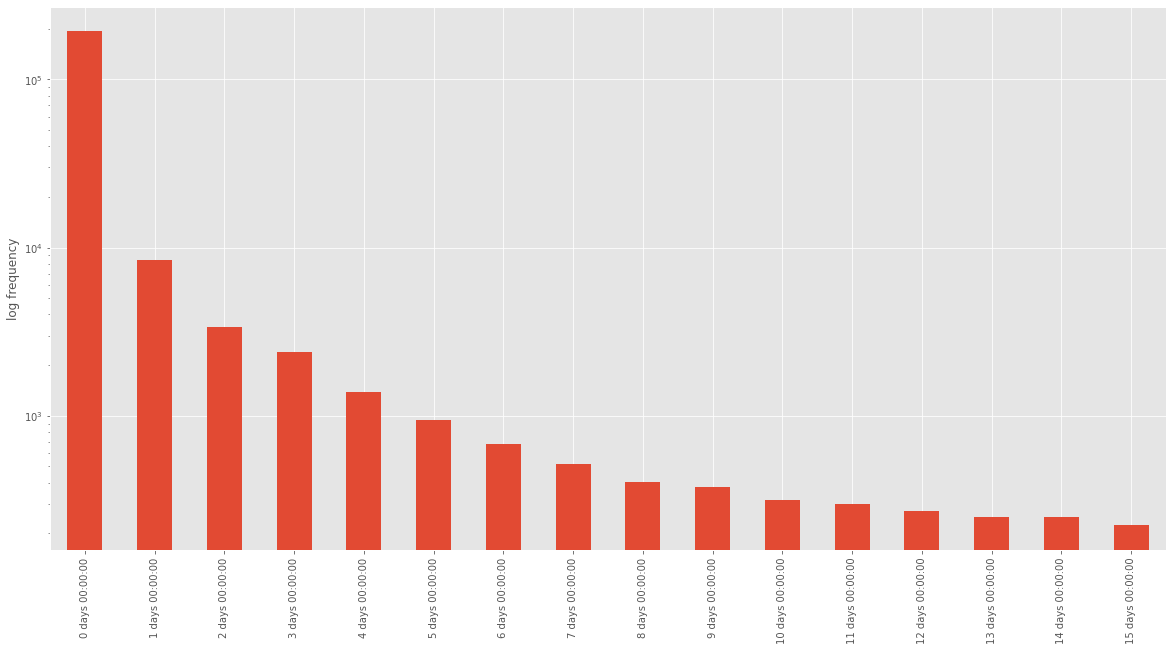

In [30]:
## 线上核销使用间隔
##对使用间隔进行排序，并且用log放大微小值， 发现绝大多数为当天使用

plot=on_cupon[(on_cupon['15天内使用']==True)]['使用间隔'].value_counts().plot(kind='bar')
plot.set_yscale('log')
plt.ylabel('log frequency')

对比每天发出的消费券核销比例可以得出：<br>
1.网络消费券整体上核销率与核销数量远大于线下发放的消费券,因此建议花费更多重心到网络消费券发放上。<br>
2.节假日对线下核销率的影响并不大，比如五一的线下核销率是小于3月21,22号的。3月21号在线下劵中拥有最高的核销比例，这可能跟当天的折扣力度以及具体消费人群有关。<br>
3.线下消费劵在周内分布并不明显，线上消费券在周一和周日领取的消费券具有最高核销率，<br>
4.核销的线上消费券的绝大多数为当天领取，当天使用。




# 根据消费券使用习惯添加X变量-特征工程

由于元气森林大部分优惠活动存在于网络电商平台，故在此选择分析online数据，以期望对元气森林的消费券策略有所启示。


## 1.消费券相关特征

根据对15天内使用的消费券折扣类型频率排序，考虑以下特征：

满减须达到的值：越高的满减金额可能越难达到，所以会影响到顾客是否使用。fixed取平均值 144.355 。

折扣比率：越高的比率更容易吸引顾客。fixed取平均值0.225。

折扣值：大的折扣值可能更醒目，更吸引顾客。fixed处理为均值19.691 。

消费券型号因素：某一种消费券可能本身做的更加成功，更容易被获取及兑换，这里取每种本身作为类别即可。 fixed处理为本身


## 2.领取时间特征，包含以下：

已经计算好的星期特征。

是否临近购物节（暂无）。

同一用户在一个月内核销过

同一用户在一个月内在相同商户核销过

同一用户使用同一类优惠券核销过



## 3.用户习惯特征，包含以下：

所有购物次数

所有领取次数

所有核销次数

所有核销概率

相同折扣率核销次数

相同折扣率核销比例

相同商家核销次数

相同商家核销比例










In [31]:
## 消费券类型排行
on_cupon[ (on_cupon['15天内使用']==True)].Discount_rate.value_counts().head(40)

fixed       131546
50:5          7251
20:10         6457
10:5          6187
50:1          5406
5:1           5011
150:10        4163
100:10        3563
30:20         3400
50:10         3139
100:5         3068
200:20        2987
50:30         2673
30:1          2307
500:50        2139
200:10        2114
100:50        1719
150:5         1679
300:50        1646
150:20        1486
300:30        1175
300:20        1001
10:1           992
300:10         894
30:5           886
200:30         805
500:20         659
100:1          597
500:100        571
150:100        551
800:50         548
800:100        500
1000:100       469
200:50         455
150:50         404
50:20          376
20:1           372
300:100        361
200:100        352
30:10          316
Name: Discount_rate, dtype: int64

In [32]:
## 比率均值
on_cupon[on_cupon['Discount_rate']!='fixed']['Discount_rate'].apply(lambda x:int(x.rpartition(':')[2])/int(x.rpartition(':')[0])).mean()

0.22524681283980225

In [33]:
## 减值均值
on_cupon[on_cupon['Discount_rate']!='fixed']['Discount_rate'].apply(lambda x:int(x.rpartition(':')[2])).mean()

19.69123703616712

In [34]:
## 满减均值
on_cupon[on_cupon['Discount_rate']!='fixed']['Discount_rate'].apply(lambda x :int(x.rpartition(':')[0])).mean()

144.35514591441003

In [35]:
on_cupon['满减值']=on_cupon['Discount_rate'].apply(lambda x:x.rpartition(':')[0]).replace('',144).astype('int')
on_cupon['折扣值']=on_cupon['Discount_rate'].apply(lambda x:x.rpartition(':')[2]).replace('fixed',20).astype('int')
on_cupon['折扣比率']=on_cupon['Discount_rate'].copy()
j=on_cupon[on_cupon['Discount_rate']!='fixed']['Discount_rate'].apply(lambda x:int(x.rpartition(':')[2])/int(x.rpartition(':')[0]))
on_cupon['折扣比率'][j.index]=j
on_cupon['折扣比率']=on_cupon['折扣比率'].replace('fixed',0.225)
on_cupon['折扣型号']=on_cupon['Discount_rate'].astype('category')



In [37]:
## 一个月内核销
k_mean=on_cupon.set_index('Date_received').sort_index().groupby('User_id').apply(lambda x: x['15天内使用'].rolling('30d').sum()).groupby(['User_id','Date_received']).last().reset_index(name='一个月内核销')
on_cupon=pd.merge(on_cupon, k_mean, on=['Date_received', 'User_id'], how='left')

In [39]:
## 一个月内同商户核销
k_mean=on_cupon.set_index('Date_received').sort_index().groupby(['User_id','Merchant_id']).apply(lambda x: x['15天内使用'].rolling('30d').sum()).groupby(['User_id','Date_received','Merchant_id']).last().reset_index(name='一个月内同商户核销')
on_cupon=pd.merge(on_cupon, k_mean, on=['Date_received', 'User_id','Merchant_id'], how='left')

In [40]:
## 一个月内同消费券核销
k_mean=on_cupon.set_index('Date_received').sort_index().groupby(['User_id','Discount_rate']).apply(lambda x: x['15天内使用'].rolling('30d').sum()).groupby(['User_id','Date_received','Discount_rate']).last().reset_index(name='一个月内同消费券核销')
on_cupon=pd.merge(on_cupon, k_mean, on=['Date_received', 'User_id','Discount_rate'], how='left')

In [44]:
## 所有购物次数
k1=ontrain.groupby('User_id').apply(lambda x: x['Date'].notnull().sum()).reset_index(name='所有购物次数')
on_cupon=pd.merge(on_cupon, k1, on= 'User_id', how='left')

In [46]:
## 所有领取次数
k2=on_cupon.groupby('User_id')['Date_received'].count().reset_index(name='所有领取次数')
on_cupon=pd.merge(on_cupon, k2, on= 'User_id', how='left')

In [76]:
## 所有核销次数
k3=on_cupon.groupby('User_id')['15天内使用'].sum().reset_index(name='所有核销次数')
on_cupon=pd.merge(on_cupon, k3, on= 'User_id', how='left')

In [77]:
## 同商户核销次数
k4=on_cupon.groupby(['User_id','Merchant_id'])['15天内使用'].sum().reset_index(name='同商户核销次数')
on_cupon=pd.merge(on_cupon, k4, on= ['User_id','Merchant_id'], how='left')

In [49]:
## 同商户核销比例
k5=on_cupon.groupby(['User_id','Merchant_id']).apply(lambda x: x['15天内使用'].sum()/x['15天内使用'].count()).reset_index(name='同商户核销比例')
on_cupon=pd.merge(on_cupon, k5, on= ['User_id','Merchant_id'], how='left')

In [78]:
## 同消费券核销次数
k6=on_cupon.groupby(['User_id','Discount_rate'])['15天内使用'].sum().reset_index(name='同消费券核销次数')
on_cupon=pd.merge(on_cupon, k6, on= ['User_id','Discount_rate'], how='left')

In [54]:
## 同消费券核销比例
k7=on_cupon.groupby(['User_id','Discount_rate']).apply(lambda x: x['15天内使用'].sum()/x['15天内使用'].count()).reset_index(name='同消费券核销比例')
on_cupon=pd.merge(on_cupon, k7, on= ['User_id','Discount_rate'], how='left')

In [149]:
data=on_cupon[['Date_received','15天内使用','星期','满减值','折扣值','折扣比率','折扣型号','一个月内核销','一个月内同商户核销','一个月内同消费券核销',
               '所有购物次数','所有领取次数','所有核销次数_y','同商户核销次数','同商户核销比例_x','同消费券核销次数_y',
               '同消费券核销比例']]

In [89]:
#所有x和y变量
data.Date_received.sort_values()

289317   2016-01-01
669061   2016-01-01
678981   2016-01-01
678982   2016-01-01
577183   2016-01-01
            ...    
435733   2016-06-15
751994   2016-06-15
29988    2016-06-15
127419   2016-06-15
231712   2016-06-15
Name: Date_received, Length: 872357, dtype: datetime64[ns]

## 划分data_received最后两个月为测试数据，之前为训练数据。

In [150]:
xvar=['星期','满减值','折扣值','折扣比率','折扣型号','一个月内核销','一个月内同商户核销','一个月内同消费券核销',
    '所有购物次数','所有领取次数','所有核销次数_y','同商户核销次数','同商户核销比例_x','同消费券核销次数_y',
    '同消费券核销比例']
yvar=['15天内使用']
train=data[data['Date_received']< '2016-04-16']
test=data[data['Date_received']> '2016-04-15']
x_train=train[xvar]
x_test=test[xvar]
y_train=train[yvar]
y_test=test[yvar]

In [151]:
ytrain=y_train.reset_index().drop(columns='index')
ytest=y_test.reset_index().drop(columns='index')

# 使用逻辑回归为baseline model，另外使用神经网络,随机森林测试表现 

In [167]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import pyrsm as rsm
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

In [152]:
# Z scale 所有 X_variables
scaler = StandardScaler()

df_scaled = scaler.fit_transform(x_train.drop(columns=['折扣型号','星期']))
xtrain = pd.DataFrame(df_scaled, columns=x_train.drop(columns=['折扣型号','星期']).columns)
xtrain['折扣型号']=x_train['折扣型号'].reset_index().drop(columns='index').astype('category')
xtrain['星期']=x_train['星期'].reset_index().drop(columns='index')

df_scaled = scaler.fit_transform(x_test.drop(columns=['折扣型号','星期']))
xtest = pd.DataFrame(df_scaled, columns=x_test.drop(columns=['折扣型号','星期']).columns)
xtest['折扣型号']=x_test['折扣型号'].reset_index().drop(columns='index').astype('category')
xtest['星期']=x_test['星期'].reset_index().drop(columns='index')





In [153]:
xtrain['星期']=xtrain['星期'].astype('category')
xtest['星期']=xtest['星期'].astype('category')

In [154]:
xtrain=pd.get_dummies(xtrain, drop_first=True)
xtest=pd.get_dummies(xtest, drop_first=True)
xtest['折扣型号_1000:5']=0

Feature: 0, Score: -0.03138
Feature: 1, Score: -0.00226
Feature: 2, Score: 0.07241
Feature: 3, Score: -0.29401
Feature: 4, Score: -0.04864
Feature: 5, Score: 1.91061
Feature: 6, Score: 0.00706
Feature: 7, Score: 0.16892
Feature: 8, Score: -0.09193
Feature: 9, Score: -0.00406
Feature: 10, Score: 1.17743
Feature: 11, Score: -0.65361
Feature: 12, Score: 3.34096
Feature: 13, Score: 0.16453
Feature: 14, Score: -0.13610
Feature: 15, Score: -0.55695
Feature: 16, Score: -0.21490
Feature: 17, Score: 0.02938
Feature: 18, Score: -0.02621
Feature: 19, Score: -0.05279
Feature: 20, Score: -0.06826
Feature: 21, Score: -0.16485
Feature: 22, Score: -0.05823
Feature: 23, Score: -0.16208
Feature: 24, Score: -0.12214
Feature: 25, Score: 0.31388
Feature: 26, Score: -0.07862
Feature: 27, Score: -0.42388
Feature: 28, Score: -0.48093
Feature: 29, Score: -0.14240
Feature: 30, Score: -0.18152
Feature: 31, Score: -0.15565
Feature: 32, Score: -0.52522
Feature: 33, Score: -0.07560
Feature: 34, Score: -0.70185
Feat

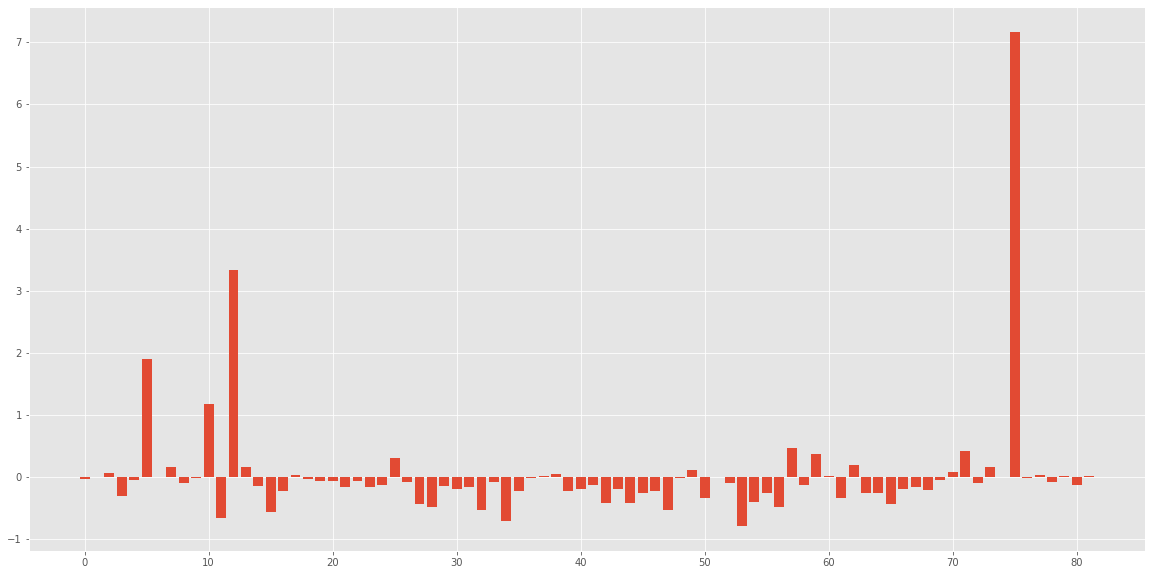

In [172]:
model1 = LogisticRegression()
model1.fit(xtrain, ytrain)

roc_auc_score(ytest, model1.predict_proba(xtest)[:,1])   
importance = model1.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [193]:
## 上图影响为正的几个变量
xtrain.columns[[5,10,12,75]]

Index(['一个月内同消费券核销', '同商户核销比例_x', '同消费券核销比例', '折扣型号_fixed'], dtype='object')

In [200]:
## 影响为负的变量
xtrain.columns[[3,11,34,47,53]]

Index(['一个月内核销', '同消费券核销次数_y', '折扣型号_150:50', '折扣型号_300:100', '折扣型号_30:10'], dtype='object')

分析logisticregressor的结果发现

1.限时特价类型的折扣会对预测结果造成非常大正面影响,这是因为全部的'fixed'类型全部为当天核销。而且fixed类型占据了大量data.

2.同时在领劵日期之前使用过更多消费券，核销比例更高的人，以及使用过相同折扣消费券的人会有更高概率再次核销.

In [183]:
on_cupon[on_cupon['Discount_rate']=='fixed']['使用间隔'].sum()

Timedelta('0 days 00:00:00')

In [184]:
on_cupon['Discount_rate'].value_counts()

fixed      131546
50:5        70964
20:10       50631
30:20       45889
5:1         42828
            ...  
300:1         160
800:10        157
1000:5         29
500:300        16
800:500         5
Name: Discount_rate, Length: 64, dtype: int64

In [189]:
roc_auc_score(ytest, model1.predict_proba(xtest)[:,1]) 

0.9840674360113498

测试集的Roc在这里过于高了，可能跟数据本身的分布以及建立的变量有自相关性有关。但是通过前面的变量重要性图示我们还是能有所启迪。

In [196]:
## random forest 随机森林

model2=RandomForestClassifier(
       n_estimators=150,
       max_depth=30, 
       max_features=5,
       min_samples_split=200)

model2.fit(xtrain, ytrain)

roc_auc_score(ytest, model2.predict_proba(xtest)[:,1])

0.9985806971733825

In [192]:
## neural network 神经网络
model3 = MLPClassifier(hidden_layer_sizes = (25,2),
                          activation = 'tanh', 
                          max_iter = 1000,
                          alpha = 0.01,
                          solver = 'sgd',
                          verbose = 0,
                          tol = 0.01,
                          learning_rate = 'adaptive',
                          learning_rate_init = 0.2)
model3.fit(xtrain, ytrain)

roc_auc_score(ytest, model3.predict_proba(xtest)[:,1])   

0.9986604084173286

几个模型的roc都很高，所以选择不再调参。

要优化预测的准确性可能得包括更多的变量，用户特征肖像，同时降低y和x的自相关性。

另外，在现有的code里rolling window包含了当天，并且取的当天最后一个值，默认为同一天的购物行为为同时发生。在变量很少以及成功的样本很多的情况下，这会带来大量自相关性，可以尝试用shift().rolling()去除掉当天的数据，但是这样可能无法捕捉当天爆炸性增长的兑换趋势。


样本本身的时间特征全部为天，如果样本本身的时间可以精细到小时，（实际数据当中应该有），应该也可以解决这个问题。

#  结论以及这个天池数据 对元气森林优惠券策略的启示 

1 元气森林可以加大对网络优惠券的投入，因为从此数据可以看出网络优惠券具有即时性，指向性，同时具有更高的核销率。

2 可以在周一，周日，促销节日，发放比平时更多的优惠券，此时的核销率更高。

3 针对已经领取并核销过同种类优惠券的客户，建议在用户界面首先推送相同的优惠券，因为这会增加核销率。

4 举行更多的限时促销活动（fixed 类型，100%的核销率有些不现实，但数据来源对此类型没有更多的描述。

5 减少'折扣型号_150:50', '折扣型号_300:100', '折扣型号_30:10'等型号的优惠券,具体型号应当根据元气森林本身产品进行调整。

6 元气森林淘宝页面大多为用户自行选择的优惠券，点击进入的大部分顾客已经有消费欲望，此时消费券并不能最大限度增加盈利，可以按照顾客以习惯增加对没有消费欲望的顾客进行消费券推送，具体推送类型可以根据客户历史肖像，具体推送人群根据此模型应当选择在领劵日期之前使用过更多消费券，核销比例更高的人，以及使用过相同折扣消费券的人。

7 根据顾客对于损失的价值评估大于收获，可增加小额付费购买更大价值消费券的类型，具有损失厌恶心理的顾客对此类消费券会有更高核销率。天猫的消费券领取流程可以根据此进行

8.根据模型概率预测以及消费券成本，可计算RIO并且将其最大化，时间与数据限制在此无法准确分析。